## model with photo/bounding box output

In [4]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO('yolo_finetuned.pt')

def visualize_predictions(predictions, img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image {img_path}")
        return
    
    print(f"Image loaded: {img_path}, shape: {img.shape}")
    
    if len(predictions) == 0 or len(predictions[0].boxes) == 0:
        print("No predictions or boxes found.")
        return
    
    boxes = predictions[0].boxes.xyxy  
    confs = predictions[0].boxes.conf  
    cls = predictions[0].boxes.cls  
    
    classifications = []

    for i in range(len(boxes)):
        x1, y1, x2, y2 = map(int, boxes[i])
        label = model.names[int(cls[i])]
        confidence = confs[i]
        classifications.append((label, confidence))

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{label}: {confidence:.2%}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    for label, confidence in classifications:
        print(f'Classification: {label}, Accuracy: {confidence:.2%}')


image 1/1 /Users/cezar/Desktop/Project One/2023-2024-projectone-ctai-sirbucezar/AI/testphotos/test1.png: 640x480 1 Glass, 51.0ms
Speed: 2.1ms preprocess, 51.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
Image loaded: testphotos/test1.png, shape: (1206, 892, 3)


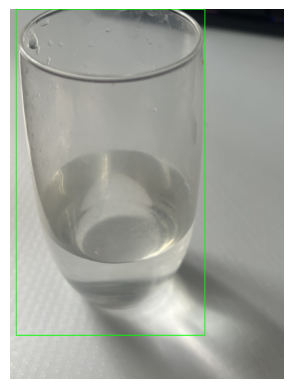

Classification: Glass, Accuracy: 82.36%


In [39]:
input_img = 'testphotos/test1.png'

predictions = model.predict(source=input_img, save=False)
visualize_predictions(predictions, input_img)

## Model with text output

In [32]:
import csv
import os
import cv2

bin_mapping = {
    'Glass': 1,
    'PMD': 2,
    'Paper': 3,
    'Rest': 4
}

csv_file_path = 'bin_logs.csv'

def initialize_csv_file(file_path):
    if not os.path.exists(file_path):
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['prediction_id', 'bin_nr', 'accuracy'])

def get_next_prediction_id(file_path):
    if not os.path.exists(file_path):
        return 1
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        if len(rows) == 1:
            return 1
        return len(rows)
    
def process_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image {img_path}")
        return None, None
    
    print(f"Image loaded: {img_path}, shape: {img.shape}")
    
    predictions = model.predict(source=img_path, save=False)
    
    if len(predictions) == 0 or len(predictions[0].boxes) == 0:
        print("No predictions or boxes found.")
        return None, None
    
    boxes = predictions[0].boxes.xyxy  
    confs = predictions[0].boxes.conf  
    cls = predictions[0].boxes.cls  
    
    classifications = []
    accuracies = []

    for i in range(len(boxes)):
        label = model.names[int(cls[i])]
        confidence = confs[i]
        classifications.append(label)
        accuracies.append(confidence)
    
    if classifications and accuracies:
        max_confidence_index = accuracies.index(max(accuracies))
        material_type = classifications[max_confidence_index]
        accuracy = accuracies[max_confidence_index]
        return material_type, accuracy

    return None, None

def log_prediction(material_type, accuracy, file_path):
    prediction_id = get_next_prediction_id(file_path)
    bin_nr = bin_mapping.get(material_type, -1)
    accuracy_percentage = accuracy * 100
    
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([prediction_id, bin_nr, f'{accuracy_percentage:.2f}'])

# Initialize the CSV file with headers
initialize_csv_file(csv_file_path)

## Input for the RasPi LCD screen | To Be Sent

In [35]:

input_img = 'testphotos/test1.png'
material_type, accuracy = process_image(input_img)

if material_type and accuracy is not None:
    print(f'Material: {material_type}, Accuracy: {accuracy:.2%}')
    log_prediction(material_type, accuracy, csv_file_path)

Image loaded: testphotos/test1.png, shape: (1206, 892, 3)

image 1/1 /Users/cezar/Desktop/Project One/2023-2024-projectone-ctai-sirbucezar/AI/testphotos/test1.png: 640x480 1 Glass, 43.3ms
Speed: 1.6ms preprocess, 43.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)
Material: Glass, Accuracy: 82.36%


## Input for the Raspi Stepper motor  | To Be Sent

In [36]:
import csv

# CSV file path
csv_file_path = 'bin_logs.csv'

def get_last_bin_nr(file_path):
    if not os.path.exists(file_path):
        print("CSV file does not exist.")
        return None
    
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        
        if len(rows) <= 1:  # Only header or empty file
            print("No predictions found in the CSV file.")
            return None
        
        last_row = rows[-1]
        bin_nr = int(last_row[1])
        return bin_nr

# Example usage
last_bin_nr = get_last_bin_nr(csv_file_path)
if last_bin_nr is not None:
    print(f'Last bin number: {last_bin_nr}') 


Last bin number: 1
